In [1]:
import sys
sys.path.append('../utils')
from nd_tools import (scale_img,
                      get_superpixel_means_as_features, 
                      get_superpixel_stds_as_features,
                      get_array_from_features)

import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm
from sklearn.cluster import KMeans
from skimage.segmentation import felzenszwalb
from skimage.color import label2rgb

In [2]:
data_dir = Path('../data')
rgb_tif = data_dir/'rgb.tif'
coh_tifs = sorted(list(data_dir.glob('./*coh*.tif')))
coh_tifs

[PosixPath('../data/alos_coh_hh.tif'), PosixPath('../data/alos_coh_hv.tif')]

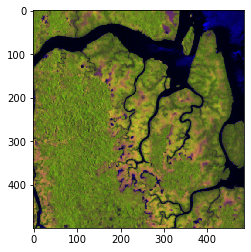

In [3]:
with rasterio.open(rgb_tif) as ds:
    rgb = ds.read().transpose([1, 2, 0])
plt.imshow(rgb)

In [4]:
superpixel_labels = felzenszwalb(rgb, scale=.5, sigma=0, min_size=15, multichannel=True)

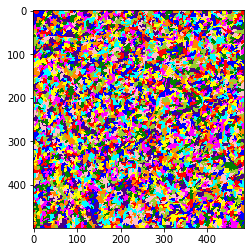

In [5]:
superpixel_labels_viz = label2rgb(superpixel_labels)
plt.imshow(superpixel_labels_viz)

In [6]:
std_features = get_superpixel_stds_as_features(superpixel_labels, rgb)
mean_features = get_superpixel_means_as_features(superpixel_labels, rgb)

/Users/cmarshak/anaconda3/envs/srspylite/lib/python3.6/site-packages/scipy/ndimage/measurements.py:523: RuntimeWarning: invalid value encountered in true_divide
  means = sums / counts


In [7]:
std_arr = get_array_from_features(superpixel_labels, std_features)
std_arr = scale_img(std_arr)
mean_arr = get_array_from_features(superpixel_labels, mean_features)

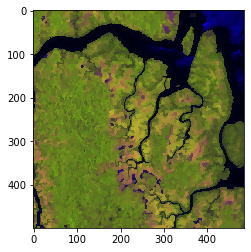

In [8]:
plt.imshow(mean_arr)

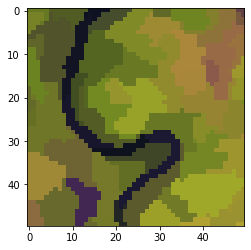

In [9]:
plt.imshow(mean_arr[200:250, 200:250])

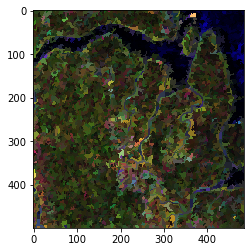

In [10]:
plt.imshow(std_arr)

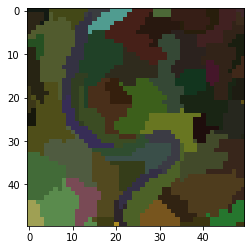

In [11]:
plt.imshow(std_arr[200:250, 200:250])

# K-means with Superpixels

In [12]:
## Answer

model = KMeans(n_clusters=3, 
               random_state=0)
X_train = mean_features.copy()
model.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

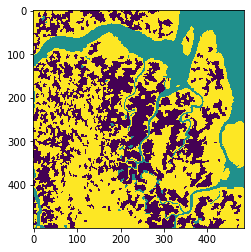

In [13]:
## Answer

class_features = model.labels_.reshape((-1, 1))
classes = get_array_from_features(superpixel_labels, class_features)
plt.imshow(classes)

# Exercise 1

Use the superpixels above to aggregate HH coherence.

In [14]:
with rasterio.open(coh_tifs[0]) as ds:
    coh_hh = ds.read(1)

In [15]:
coh_std_features = get_superpixel_stds_as_features(superpixel_labels, coh_hh)
coh_mean_features = get_superpixel_means_as_features(superpixel_labels, coh_hh)

/Users/cmarshak/anaconda3/envs/srspylite/lib/python3.6/site-packages/scipy/ndimage/measurements.py:523: RuntimeWarning: invalid value encountered in true_divide
  means = sums / counts


In [16]:
coh_std_arr = get_array_from_features(superpixel_labels, coh_std_features)
coh_std_arr = scale_img(coh_std_arr)
coh_mean_arr = get_array_from_features(superpixel_labels, coh_mean_features)

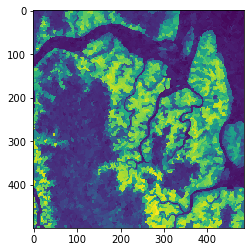

In [17]:
plt.imshow(coh_mean_arr)

# Exercise 2

Use the superpixels coherence with k-means.

In [18]:
## Answer

model = KMeans(n_clusters=3, 
               random_state=0)
X_train = coh_mean_features.copy()
model.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

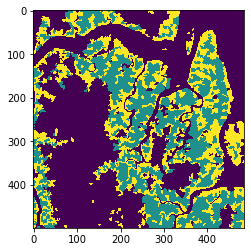

In [19]:
## Answer

class_features = model.labels_.reshape((-1, 1))
classes = get_array_from_features(superpixel_labels, class_features)
plt.imshow(classes)

That's a pretty good classification, but what two classes are being conflated? Ideas for separating them?


# Exercise 3

Combine coherence and backscatter.

In [20]:
## Answer

model = KMeans(n_clusters=4, 
               random_state=0)
X_train = np.concatenate([mean_features, coh_mean_features], axis=1)
model.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

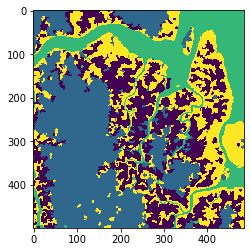

In [21]:
class_features = model.labels_.reshape((-1, 1))
classes = get_array_from_features(superpixel_labels, class_features)
plt.imshow(classes)

In [22]:
## Answer
with rasterio.open(coh_tifs[0]) as ds:
    profile = ds.profile

profile['dtype'] = 'int32'
profile['nodata'] = None
with rasterio.open('classes.tif', 'w', **profile) as ds:
    ds.write(classes.astype(np.int32), 1)

# Acknowledgements

A portion of this research was performed at the Jet Propulsion Laboratory, California Institute of Technology. Copyright 2019 California Institute of Technology. US Government Support Acknowledged.
